## DATA 다운로드

In [3]:
# $ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip
# $ unzip song_lyrics.zip -d ~/aiffel/lyricist/data/lyrics  #lyrics 폴더에 압축풀기

## DATA 읽어오기

In [4]:
import os, re 
import numpy as np
import tensorflow as tf

# 파일을 읽기모드로 열고
# 라인 단위로 끊어서 list 형태로 읽어옵니다.
file_path = os.getenv('HOME') + '/aiffel/lyricist/data/shakespeare.txt'
with open(file_path, "r") as f:
    raw_corpus = f.read().splitlines()

# 앞에서부터 10라인만 화면에 출력해 볼까요?
print(raw_corpus[:10])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '', 'All:']


## 데이터 정제하기

In [5]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx >15: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?
Resolved. resolved.
First, you know Caius Marcius is chief enemy to the people.


### 특수문자 제거하기

In [6]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()   
    # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
     # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r'[" "]+', " ", sentence) 
     # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) 

    sentence = sentence.strip()
    # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    sentence = '<start> ' + sentence + ' <end>'      
    
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


#### 생각보다 특수문자를와 공백을 제거하는게 중요하다. 그래야, 뭔하는 데이터를 추출할수있다.  

In [7]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

## 데이터 TOKENIZE

In [8]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.
	
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           padding='post',
                                                          maxlen=maxlen)  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    3    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    3    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f3505f66110>


#### 여기서 인제 데이터를 토큰화 시켜서 작업을 해줍니다. 
#### *중요한점! 문자을 쪼개서 기계가 이해할 수 있는 백터로 변환시켜주는 과정입니다. 

In [9]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of


In [10]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0]


## 평가 DATASET 분리하기 

In [12]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)

In [13]:
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (19212, 14)
Target Train:  (19212, 14)


In [14]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[ 2.5444975e-04, -3.0769927e-05, -6.8083122e-05, ...,
          2.9901008e-05,  2.2177410e-04,  4.8661448e-05],
        [ 2.9154558e-04, -2.5571664e-04, -3.9993324e-06, ...,
          1.3915934e-05,  6.9983036e-04, -3.1352075e-04],
        [ 1.3747817e-04, -7.4886269e-04, -4.9894017e-05, ...,
         -2.1929319e-04,  1.0886411e-03, -3.5305443e-04],
        ...,
        [ 2.8578090e-04,  1.1267739e-03, -2.2204621e-03, ...,
          2.1895167e-04,  5.9269957e-04,  7.3182891e-04],
        [ 5.7582353e-04,  1.5711521e-03, -2.3009535e-03, ...,
          1.4861337e-04,  1.7640201e-04,  6.5409456e-04],
        [ 7.9996517e-04,  1.9267178e-03, -2.3689021e-03, ...,
          6.5577020e-05, -2.3478028e-04,  5.5792974e-04]],

       [[ 2.5444975e-04, -3.0769927e-05, -6.8083122e-05, ...,
          2.9901008e-05,  2.2177410e-04,  4.8661448e-05],
        [ 1.8204842e-04, -4.8926900e-05,  3.4153534e-06, ...,
          2.7958873e-05,  

In [14]:
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (19212, 14)
Target Train:  (19212, 14)


In [15]:
from tensorflow.keras.layers import Embedding, LSTM, Dense


## Artificial Intelligent 만들기

#### 먼저 MODEL HISTORY 그래프를 만들어 보자.
##### * 여기서 모젤이 학습이 잘되기 위해 함수를 졍의해주자!

In [16]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

In [18]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = LSTM(hidden_size, return_sequences=True)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 19
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)


## 모델 합습하기  

In [19]:
history = []
epochs = 10

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

history = model.fit(enc_train, 
          dec_train, 
          epochs=epochs,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/10
76/76 [==============================] - 79s 733ms/step - loss: 5.6331 - val_loss: 4.6904
Epoch 2/10
76/76 [==============================] - 55s 726ms/step - loss: 4.2746 - val_loss: 4.0546
Epoch 3/10
76/76 [==============================] - 55s 726ms/step - loss: 3.9649 - val_loss: 3.9528
Epoch 4/10
76/76 [==============================] - 55s 724ms/step - loss: 3.8205 - val_loss: 3.8249
Epoch 5/10
76/76 [==============================] - 55s 720ms/step - loss: 3.6521 - val_loss: 3.7519
Epoch 6/10
76/76 [==============================] - 54s 716ms/step - loss: 3.5345 - val_loss: 3.7239
Epoch 7/10
76/76 [==============================] - 55s 723ms/step - loss: 3.4324 - val_loss: 3.6991
Epoch 8/10
76/76 [==============================] - 55s 719ms/step - loss: 3.3197 - val_loss: 3.6961
Epoch 9/10
76/76 [==============================] - 55s 720ms/step - loss: 3.1986 - val_loss: 3.6930
Epoch 10/10
76/76 [==============================] - 55s 723ms/step - loss: 3.0664 - val_lo

#### 이포크 10개 돌렸을때 1.1점 떨어졌습니다. 
#### 생각보다 학습시간이 빨랐습니다.

In [20]:
import matplotlib.pyplot as plt

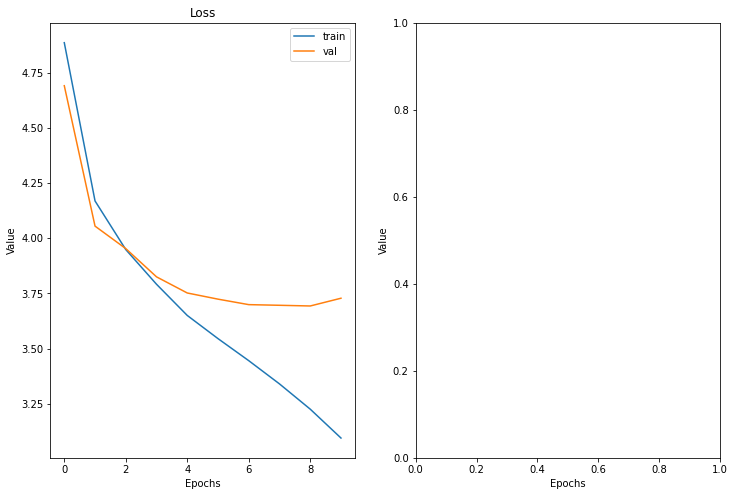

In [21]:
 plot_curve(history.epoch, history.history, ['loss', 'val_loss'])

#### 생각보다 EPOCH 0-2까지 갑이 너무 빨리 떨어진다는 점..

In [22]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측하지 않았거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [24]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , sir , i ll tell you . <end> '

### RESULT:

#### 생각보다 음 NLP는 사람들 의식 하는게 부족하다.